# RSLDS 코드

## 코드 사용 설명
데이터 denoising, rslds 및 pcr 분석 코드입니다.

필수로 수정해야 하는 코드는 바로 아래의 Parameters 셀 부분입니다. 이 외에 rslds의 state dimension, trajectory의 이동평균선 window 등의 세부적인 파라미터는 해당 부분에서 수정해가며 실행해주세요. Shift + Enter를 누르면 행을 순차적으로 실행하며 다음 행으로 진행할 수 있습니다.

주석은 대부분 코딩을 할 때 달아놓은 것이라 읽으실 필요는 없습니다. 꼭 읽어야 하는 설명은 마크다운 셀에 적었습니다.

# Parameters
## LABEL
***data_preprocess 파일에서 사용했던 LABEL을 그대로 복사해주세요.*** 여기서 특히 내부적으로 -2, -1로 각각 라벨링 했던 closeopen과 hitass를 'closeopen'과 'back'의 state를 이용하여 변경하기 때문에 특히 신경써주세요.

## PATH
***data_preprocess 파일에서 마지막에 저장했던 파일을 불러오기 위해 상대경로를 지정해줍니다.*** 파일명과 확장자까지 넣어야 하는 점 유의해주세요.

In [1]:
# State label dict
LABEL = {
    'closeopen': 0,
    'search': 1, 
    'fz': 1, 
    'eat': 1, 
    'back': 0, 
    'hitass': -1,   # -1로 고정해주세요.
    'none': 2
}

PATH = '../../data/preprocessed/230406_4.csv'

### import 및 utility 함수 정의
get_time_const와 get_line_attractor_score는 cell 논문의 수식대로 구현하였습니다. 이 외의 함수는 ssm 예시 파일에 있던 함수를 이용하였습니다. 굳이 내부 구현을 보실 필요는 없습니다.

In [2]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green", 'black']
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")
import pandas as pd

import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import scipy.stats as stats
from scipy.stats import kstest

import sklearn
# from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd

color_names = [
    "red",
#     "orange",
    "amber",
    "faded green",
    "windows blue",
    "dusty purple",
    "black",
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-", window=5):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    x_ma = x.copy()
    x_ma[:,0] = np.convolve(x[:,0], np.ones(window), 'same') / window
    x_ma[:,1] = np.convolve(x[:,1], np.ones(window), 'same') / window
    
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x_ma[start:stop + 1, 0],
                x_ma[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax, x_ma

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

def get_time_const(model, state=-1):
    eigvals = np.linalg.eigvals(rslds_lem.dynamics.As[state])
    time_const = abs(1 / np.log(abs(eigvals.real)))
    time_const_sorted = np.sort(time_const)[::-1]
    arg_sorted = np.argsort(time_const)[::-1]
    return time_const_sorted, arg_sorted

def get_line_attractor_score(time_const_sorted):
    return np.log2(time_const_sorted[0] / time_const_sorted[1])

## Load Data
전처리한 데이터를 numpy 배열로 불러옵니다.

obs : state를 제외한 테이블 값으로, miniscope 값  (miniscope에 해당하는 데이터는 denoising 이후 z_scores 변수로 사용)  
z : 테이블의 마지막 열로, state 값

In [3]:
data = np.loadtxt(PATH, delimiter=',')
obs = data[:, 1:-1].astype(float)
z = data[:, -1].astype(int)

### Get hitass indices
hitass가 존재하는 index들을 추출해 이후 trial 구분 등에 이용합니다. 추출 후 hitass의 state는 'back'의 state와 동일하게 변경합니다.

hitass_indices : hitass가 존재하는 index들의 배열

In [4]:
hitass_indices = np.where(z == -1.0)[0]
hitass_indices

array([ 1691,  3195,  4673,  6796,  8431, 10210, 12017, 13533, 15184,
       17073, 19027, 20579, 22008, 24563, 26123, 28571, 30183, 32013,
       33607, 34871, 36444, 37679, 39496, 41477])

In [5]:
# set hitass(-1) to LABEL['back']
z[hitass_indices] = LABEL['back']

### Normalize each cells (Denoising)
노이즈를 제거하는 부분입니다. 여러가지 방법이 이용될 수 있으나 최적의 방법을 아직 찾지 못한 상태라 closeopen 상태를 각 trial의 baseline으로 잡아 z-score로 변환하는 코드를 남겨두었습니다. 이 때 closeopen 상태를 이용하기 위해 data_preprocess 파일에서 내부적으로 closeopen의 state를 -2로 지정했었습니다.  

이외에 여러 시도들을 아카이빙 해놓은 파일이 있으나 대부분 자동화되지 않은 수작업이고, 데이터의 상태나 state등에 따라 denoising해야하는 방식에 차이가 있어 일단 제외하였습니다.

In [6]:
# hitass_indices의 앞에 0을 추가하여 trial 구분에 이용할 trial_indices 생성
trial_indices = np.hstack(([0], hitass_indices))
trial_indices

array([    0,  1691,  3195,  4673,  6796,  8431, 10210, 12017, 13533,
       15184, 17073, 19027, 20579, 22008, 24563, 26123, 28571, 30183,
       32013, 33607, 34871, 36444, 37679, 39496, 41477])

In [7]:
# 각 trial별로 closeopen 상태 base로 z-score
z_scores = np.zeros_like(obs)
for i in range(len(trial_indices) - 1):
    trial = obs[trial_indices[i]:trial_indices[i+1], :]
    z_trial = z[trial_indices[i]:trial_indices[i+1]]
    mean = trial[z_trial == -2].mean(axis=0)    
    std = trial[z_trial == -2].std(axis=0)
    z_scores[trial_indices[i]:trial_indices[i+1], :] = (trial - mean) / std

/var/folders/7p/wd46twpj5yj_sg6typcw5pvm0000gn/T/ipykernel_43810/3623490760.py:8: RuntimeWarning: divide by zero encountered in true_divide
  z_scores[trial_indices[i]:trial_indices[i+1], :] = (trial - mean) / std
/var/folders/7p/wd46twpj5yj_sg6typcw5pvm0000gn/T/ipykernel_43810/3623490760.py:8: RuntimeWarning: invalid value encountered in true_divide
  z_scores[trial_indices[i]:trial_indices[i+1], :] = (trial - mean) / std


In [8]:
z[z==-2] = LABEL['closeopen']
z.shape

(41478,)

### Take first two trials
가장 앞의 두 trial을 추출하여 분석에 이용하고자 합니다.

hitass_indices를 이용하여 trial을 자유롭게 추출할 수 있습니다.

ex) 앞의 세 trial 추출 : hitass_indices[1]을 hitass_indices[2]로 변경

In [9]:
z_scores = obs
z_scores.shape

(41478, 41)

In [10]:
# take first two trials
z_scores = z_scores[:hitass_indices[1], :]
z = z[:z_scores.shape[0]]

print(z_scores.shape)
print(z.shape)

(3195, 41)
(3195,)


## Plot z-scores for sanity check
denoising 이후의 miniscope 데이터에서 뉴런 몇 개를 plotting 해봅니다.  
plot_n의 값을 바꿔 출력할 뉴런의 개수를 변경할 수 있고, figsize로 figure의 크기도 조정 가능합니다.

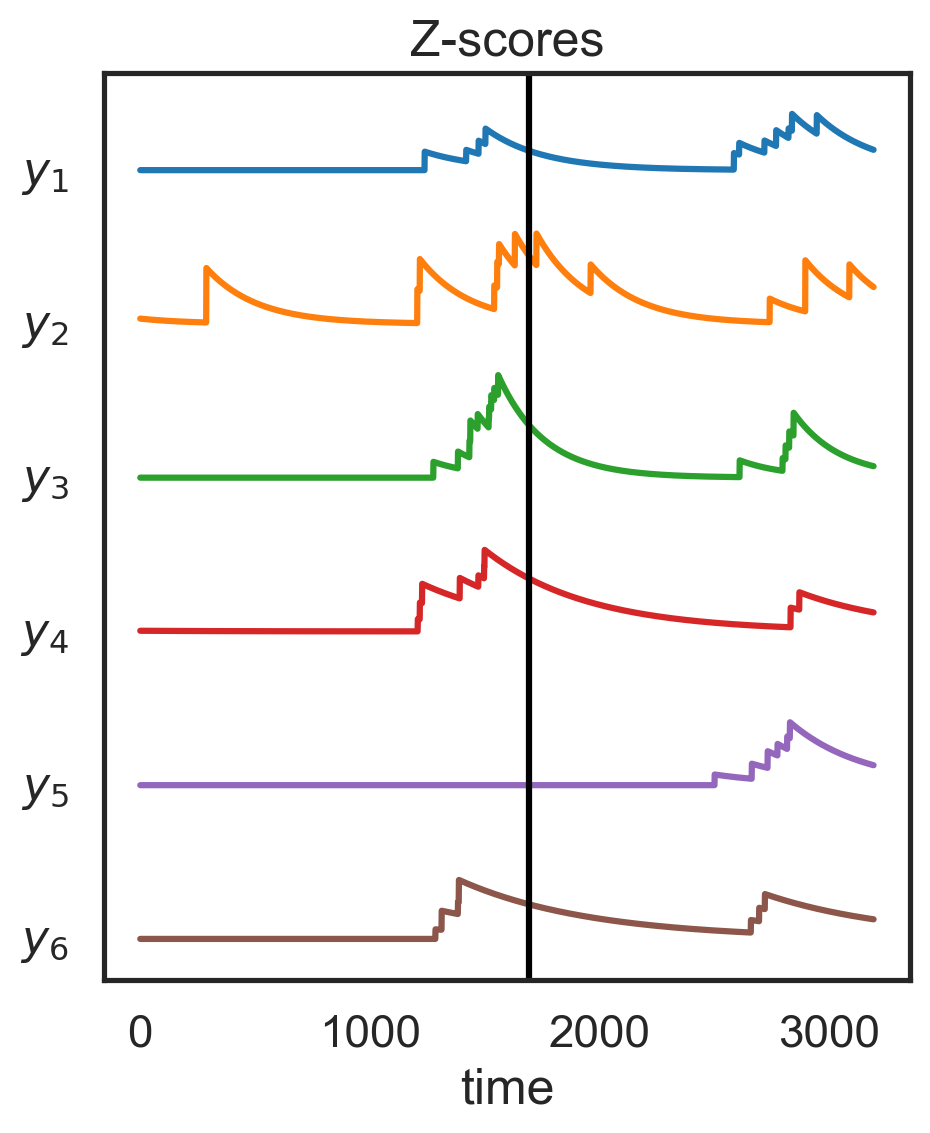

In [11]:
plot_n = 6

plt.figure(figsize=(5, 6))
# plt.imshow([None,:],
#            aspect="auto",
#            cmap=cmap,
#            vmin=0,
#            vmax=len(colors)-1,
#            extent=(0, plot_n, -lim, (obs_dim)*lim))

lim = abs(obs).max()
for n in range(plot_n):
    plt.plot(z_scores[:, n] - lim * n, '-')
plt.axvline(x=hitass_indices[0], color='black')
# plt.axvline(x=hitass_indices[1], color='black')
plt.yticks(-np.arange(plot_n) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(plot_n)])
plt.xlabel("time")

plt.title("Z-scores")
plt.tight_layout()

## Plot z-scores for sanity check
denoising 이후의 miniscope 데이터에서 뉴런 전체를 plotting 해봅니다. 
여기서 색은 state를 나타내는 것으로, 0부터 시작하여 무지개 색 순서로 변합니다. figsize로 figure의 크기도 조정 가능합니다.  

주석처리한 plt.axvline 코드처럼 trial을 구분하는 수직선을 얼마든지 추가 가능합니다. (추출한 trial 개수보다 많을 경우 오류가 발생할 수 있습니다.)

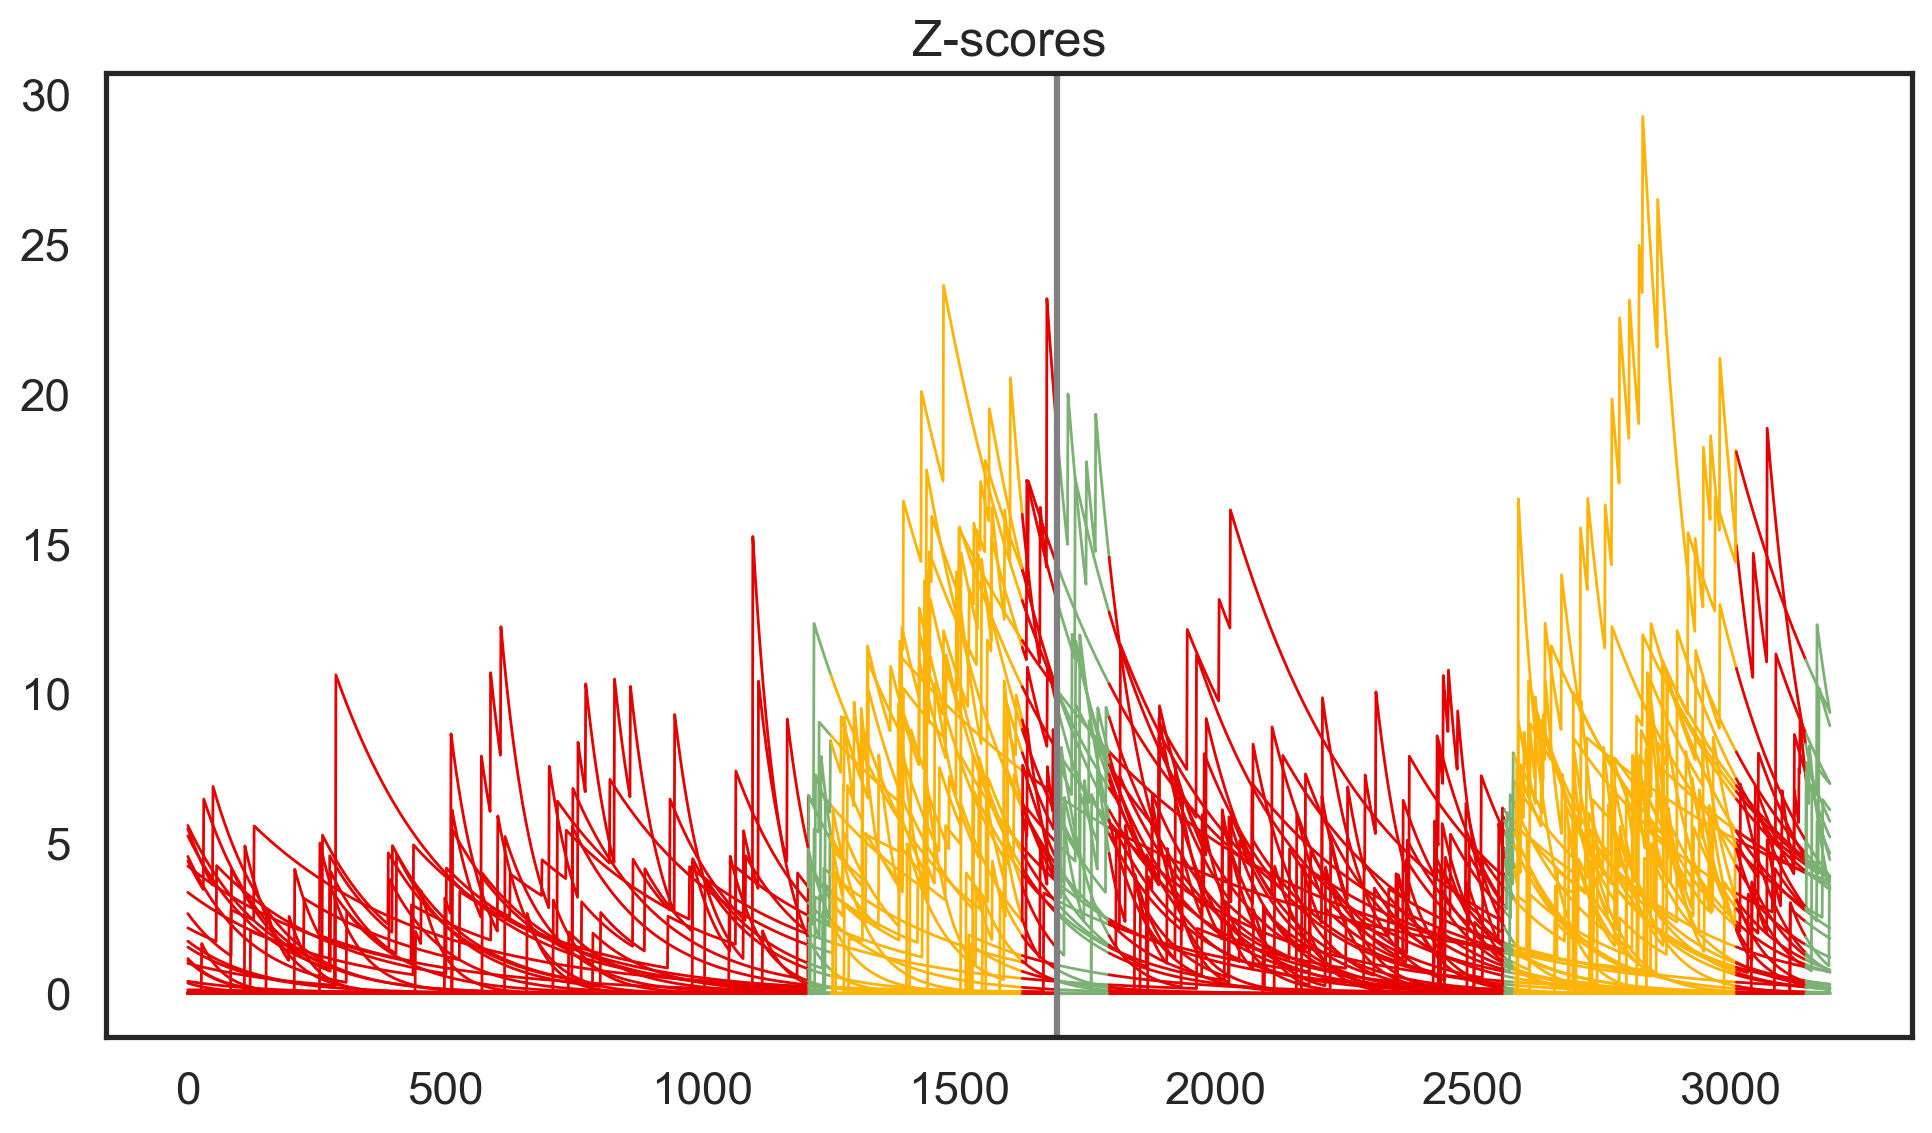

In [12]:
fig = plt.figure(figsize=(10, 6)) 
gs = gridspec.GridSpec(1, 1) 
ax = fig.add_subplot(gs[0])

plot_observations(z[:], z_scores[:,:], ax=ax)
plt.axvline(x=hitass_indices[0], color='grey')
# plt.axvline(x=hitass_indices[1], color='grey')
plt.title("Z-scores")
plt.tight_layout()

# Fitting an rSLDS
rSLDS 모델을 학습하는 코드입니다.

### Parameters
T, K, D_obs는 각각 timebin 수, state의 수, 뉴런의 수이며, 자동으로 지정되니 수정하지 않습니다.  
**D_latent 만이 변경할 대상이며, rslds 분석 후 나올 latent variable의 차원을 나타냅니다. (보통 클수록 시간이 더 오래 걸리며 elbo값은 올라가지만, 어느정도 값 이상에선 성능이 오히려 감소할 수 있습니다.)**

In [13]:
# Global parameters
T = z_scores.shape[0]
K = np.max(z) + 1
D_obs = z_scores.shape[1]
D_latent = 7

## rslds 모델 세팅
transitions, method, variational_posterior 등의 매개변수는 변경하면 안 됩니다.  
dynamics와 emissions는 다양한 옵션이 있지만 gaussian이 가장 좋은 것으로 보여 웬만하면 수정하지 않습니다.  
**변경할 수 있는 것은 num_iters 정도인데, 이는 학습의 iteration 수입니다. 다만 약간 변경해도 큰 변화는 없는 것 같습니다.**

In [14]:
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="gaussian",
             emissions="gaussian",
             single_subspace=True)
rslds.initialize(z_scores)
q_elbos_lem, q_lem = rslds.fit(z_scores, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, z_scores)))
zhat_lem = rslds.most_likely_states(xhat_lem, z_scores)

# store rslds
rslds_lem = copy.deepcopy(rslds)

  0%|          | 0/100 [00:00<?, ?it/s]

### Checking Convergence
elbo의 수렴성을 확인합니다. ***일차적으로 elbo가 수렴하지 않는다면 학습이 잘 되지 않은 것으로 판단합니다.***  
elbo는 trial을 적게, closeopen 등 크게 중요하지 않은 부분을 짧게 가져갈수록 높아지는 경향이 있으며 적절한 데이터 가공에 따라 양수가 나온 적도 있습니다. ***다만 elbo가 이후에 나올 variance explained score를 보장하지는 않습니다.***

Text(0, 0.5, 'ELBO')

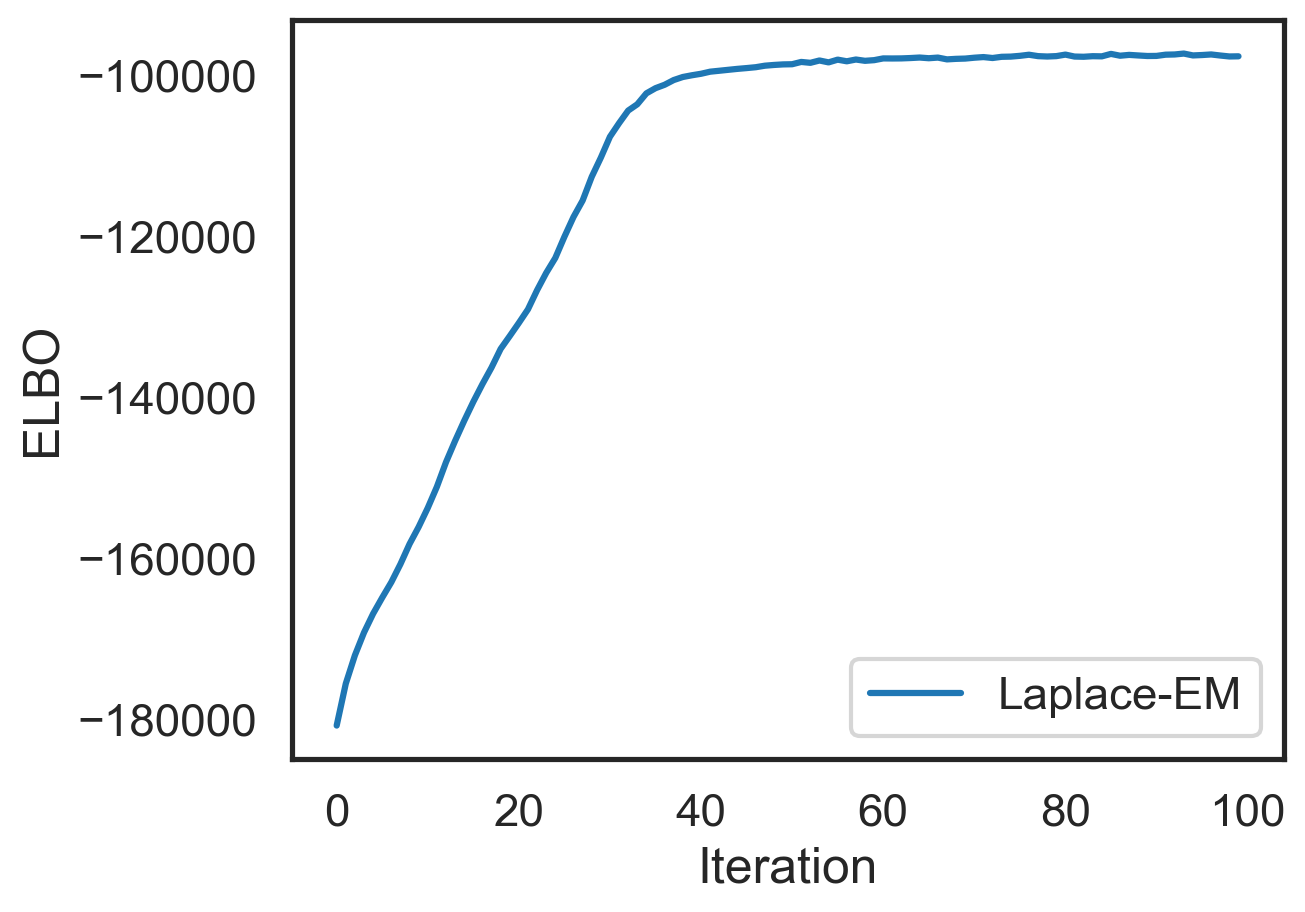

In [15]:
# Plot some results
plt.figure()
plt.plot(q_elbos_lem[1:], label="Laplace-EM")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("ELBO")

## Get variance explained score
학습된 rslds 모델로부터 z_pred(state)와 y_pred(z_score)를 샘플링하여 실제 값과 비교합니다.  
샘플링에 랜덤성이 있어 100번 반복하여 score의 평균을 구했습니다.(하단 코드의 100 값을 수정하여 횟수를 변경할 수 있습니다.)  
score를 계산하는 메소드는 sklearn의 함수를 이용했으며, 내부적으로 R^2 score와 유사합니다. 

또한 z_score와 y_pred를 각각 모든 차원(뉴런)에 대해 평균 내어 둘의 차이를 대략적으로 시각화합니다.

Explained Variance for z-scores: -0.43990067551979245
Explained Variance for states: -0.3373159389349663


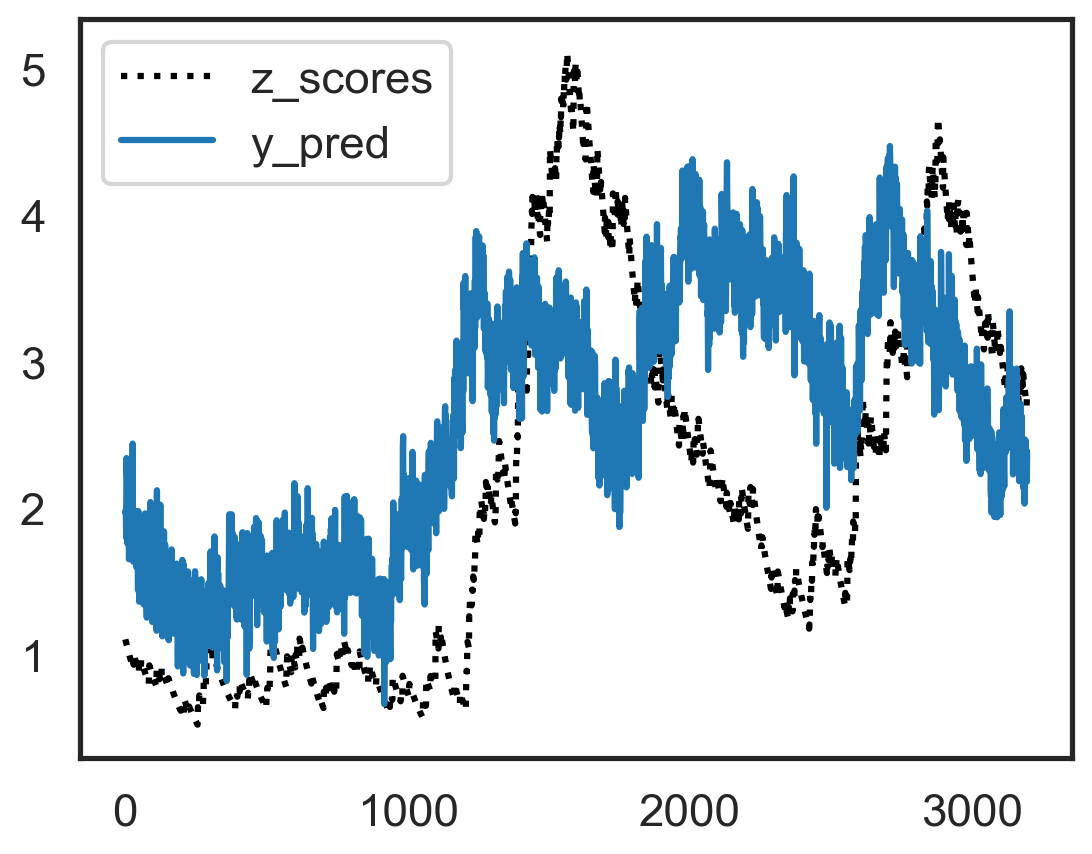

In [28]:
y_exp_var = []
z_exp_var = []
for i in range(100):
    z_pred, x_pred, y_pred = rslds.sample(z_scores.shape[0], with_noise=False)

    y_exp_var.append(sklearn.metrics.explained_variance_score(z_scores, y_pred))
    z_exp_var.append(sklearn.metrics.explained_variance_score(z, z_pred))

plt.plot(z_scores.mean(axis=1), 'k:', label='z_scores')
plt.plot(y_pred.mean(axis=1), '-', label='y_pred')
plt.legend()

print("Explained Variance for z-scores:", np.mean(y_exp_var))
print("Explained Variance for states:", np.mean(z_exp_var))

## PCA Stats
PCA를 이용해 2차원으로 차원축소하고 variance explained 값을 확인합니다. 모두 sklearn에 구현된 pca 메소드를 사용했습니다.

In [17]:
pca = PCA(n_components=2)
pca.fit(xhat_lem)
xhat_lem_pca = pca.transform(xhat_lem)

xhat_lem_pca.shape

(3195, 2)

In [18]:
# PC1, PC2에 대한 explained variance ratio
pca.explained_variance_ratio_

array([0.53893613, 0.18612888])

In [19]:
# PC1 + PC2로 설명 가능한 variance 비율
pca.explained_variance_ratio_.sum()

0.7250650148439295

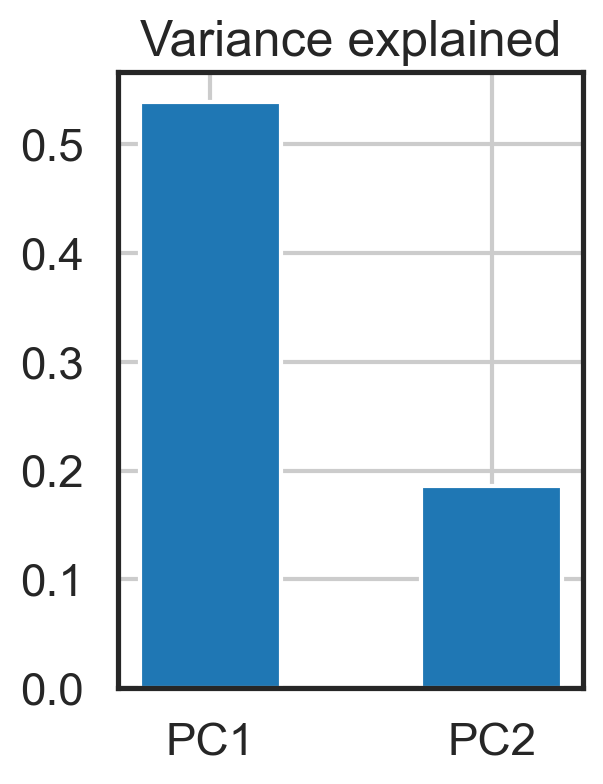

In [20]:
plt.figure(figsize=(3,4))
plt.title('Variance explained')
plt.bar(['PC1', 'PC2'], pca.explained_variance_ratio_, width=0.5)
plt.grid(True)

## Calculating time constants
cell 논문의 time constant 설명과 동일하게 구현했습니다.  
rslds의 latent variable의 각 차원에 대해, 'eat' state에서의 time constant를 구합니다.

In [21]:
time_const_sorted, arg_sorted = get_time_const(rslds_lem, state=LABEL['eat'])
time_const_sorted

array([311.76334533, 278.92184694, 259.65146549, 247.75446004,
       157.22256356, 115.01863595,  91.68908809])

Text(0, 0.5, 'Time constant (s)')

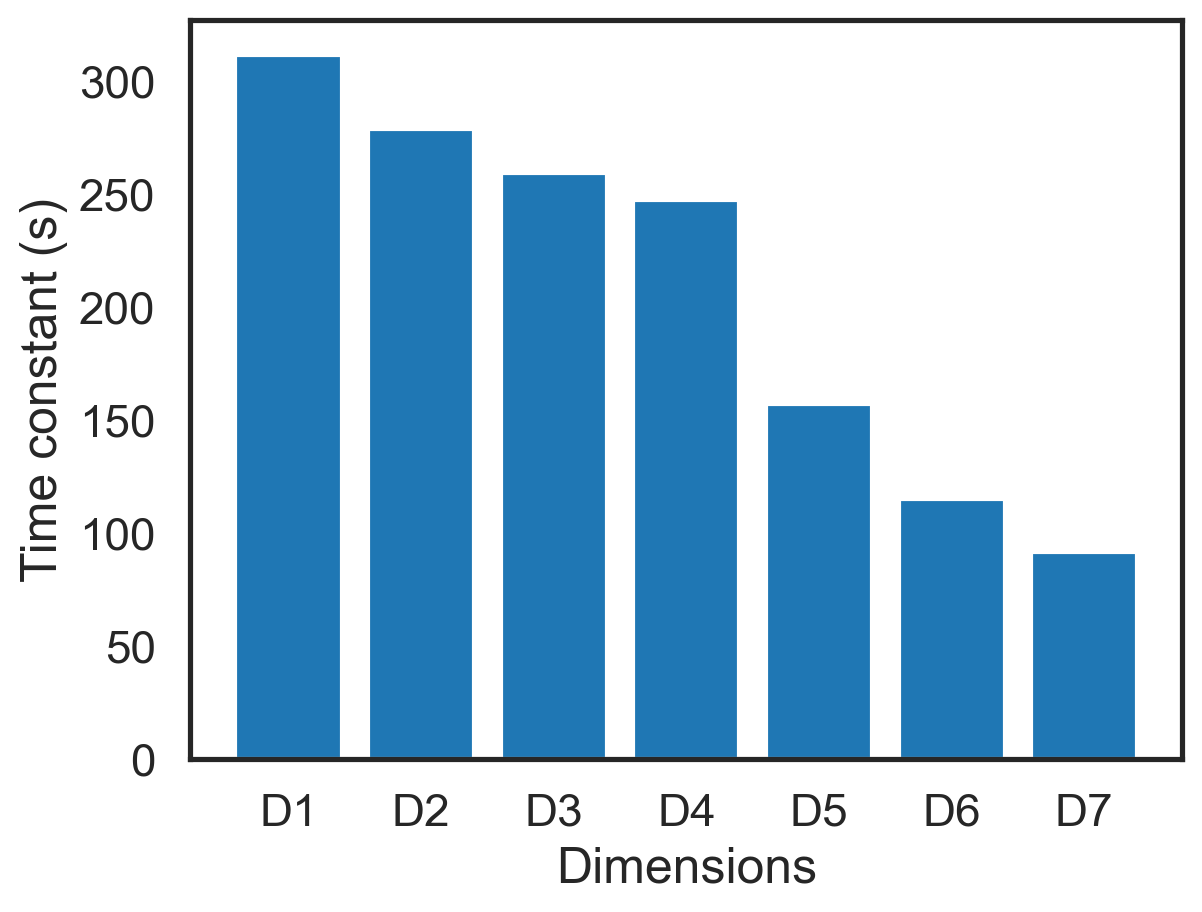

In [22]:
plt.bar(x = range(D_latent), height = time_const_sorted)

plt.xticks(range(D_latent), [f'D{i+1}' for i in range(D_latent)])
plt.xlabel('Dimensions')
plt.ylabel('Time constant (s)')

### Line attractor score
cell 논문에서의 수식을 이용해 계산했습니다.  
line attractor가 존재할 경우 이 값이 1을 넘을 것이라고 논문에서 가정하고 있습니다.

In [23]:
line_attractor_score = get_line_attractor_score(time_const_sorted)
line_attractor_score

0.16059037742294482

## Visualizing Trajectory
pca를 시행한 후의 PC1과 PC2를 이용해 neural trajectory를 그려봅니다. 여기서 색은 state를 나타내며 0부터 무지개색 순서로 변합니다.  
trajectory가 너무 복잡해지는 것을 방지하기 위해 이동평균으로 smoothing 했습니다. **바로 밑의 window 변수를 변경해 이동평균의 window를 지정할 수 있습니다.**

그 아래의 cell은 trajectory에 neural dynamic을 그리는 코드입니다.  
**다만 아쉽게도 latent dimension을 2로 했을 때만 그릴 수 있습니다... 그 외에는 오류가 발생하는데 그냥 무시하고 진행하시면 됩니다.**

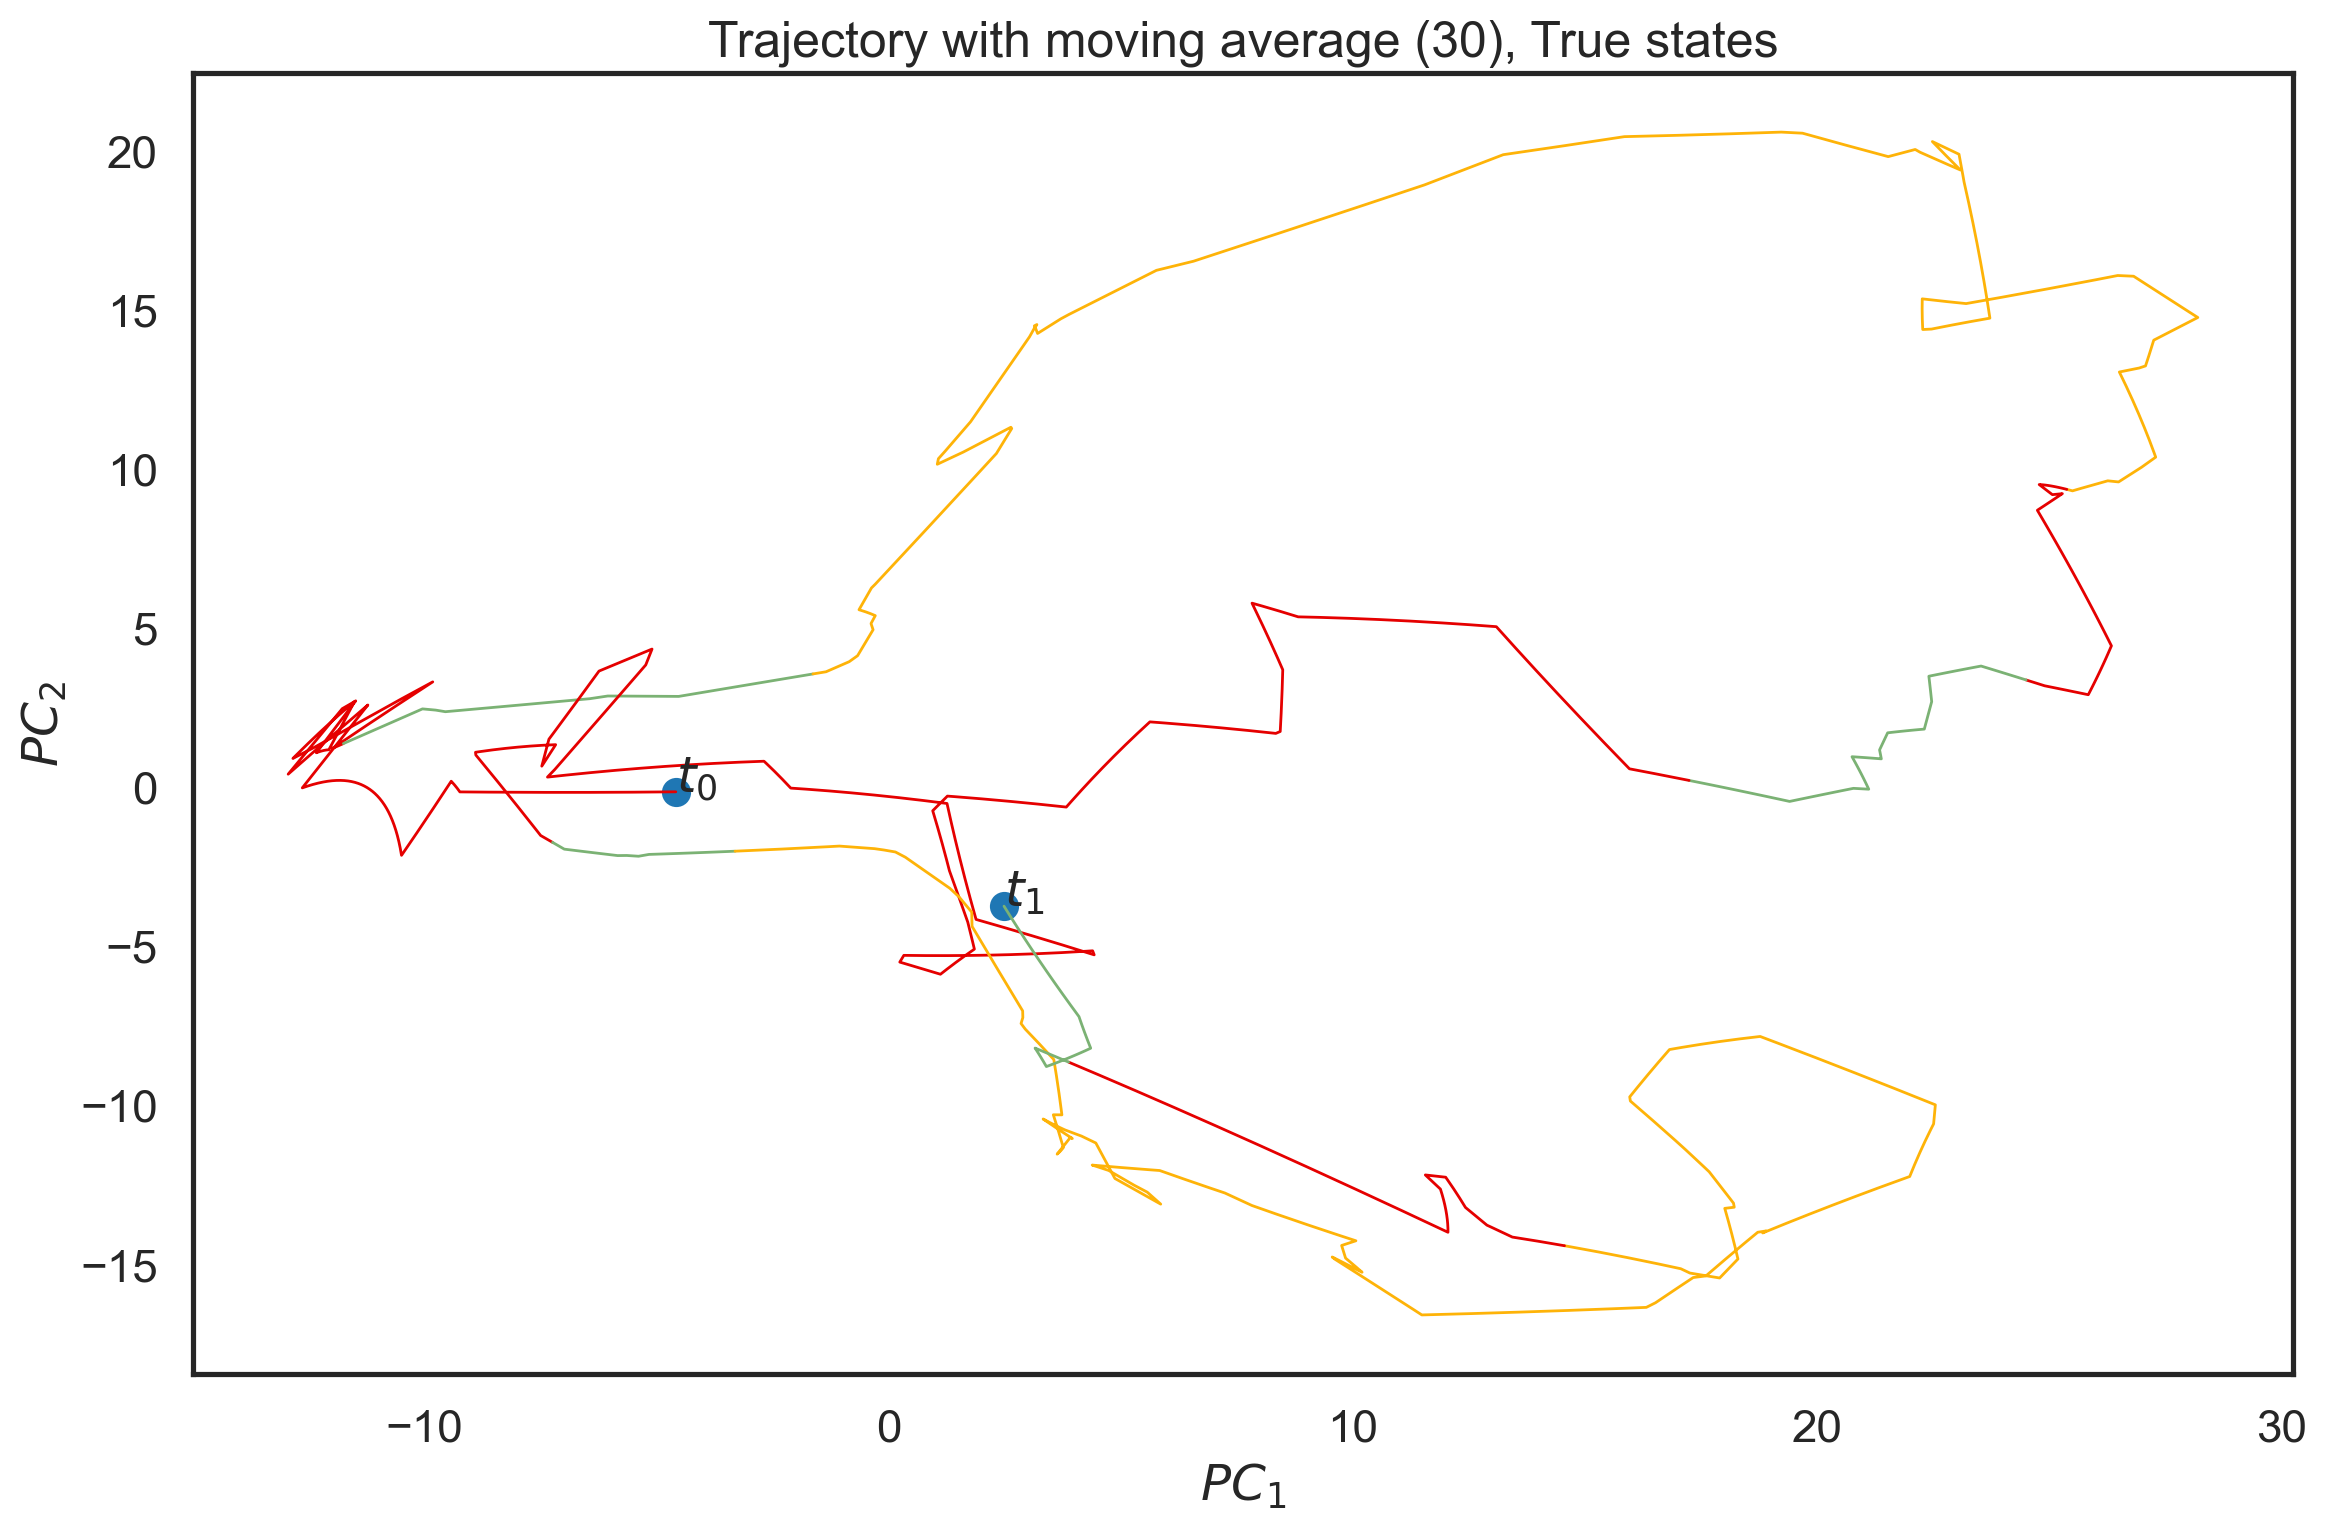

In [24]:
window = 30

plt.figure(figsize=[12, 8])
ax = plt.subplot(gs[0])
_, xhat_ma = plot_trajectory(z, xhat_lem_pca, ax=ax, window=window)
xhat_hitass = xhat_ma[hitass_indices[:0]]

x_values = [xhat_ma[0, 0]] + xhat_hitass[:,0].tolist() + [xhat_ma[-1, 0]]
y_values = [xhat_ma[0, 1]] + xhat_hitass[:,1].tolist() + [xhat_ma[-1, 1]]
plt.scatter(x_values, y_values)
for i in range(len(x_values)):
    plt.text(x_values[i], y_values[i], f"$t_{i}$")
plt.xlabel("$PC_1$")
plt.ylabel("$PC_2$")
plt.title(f"Trajectory with moving average ({window}), True states")
plt.tight_layout()

AssertionError: 

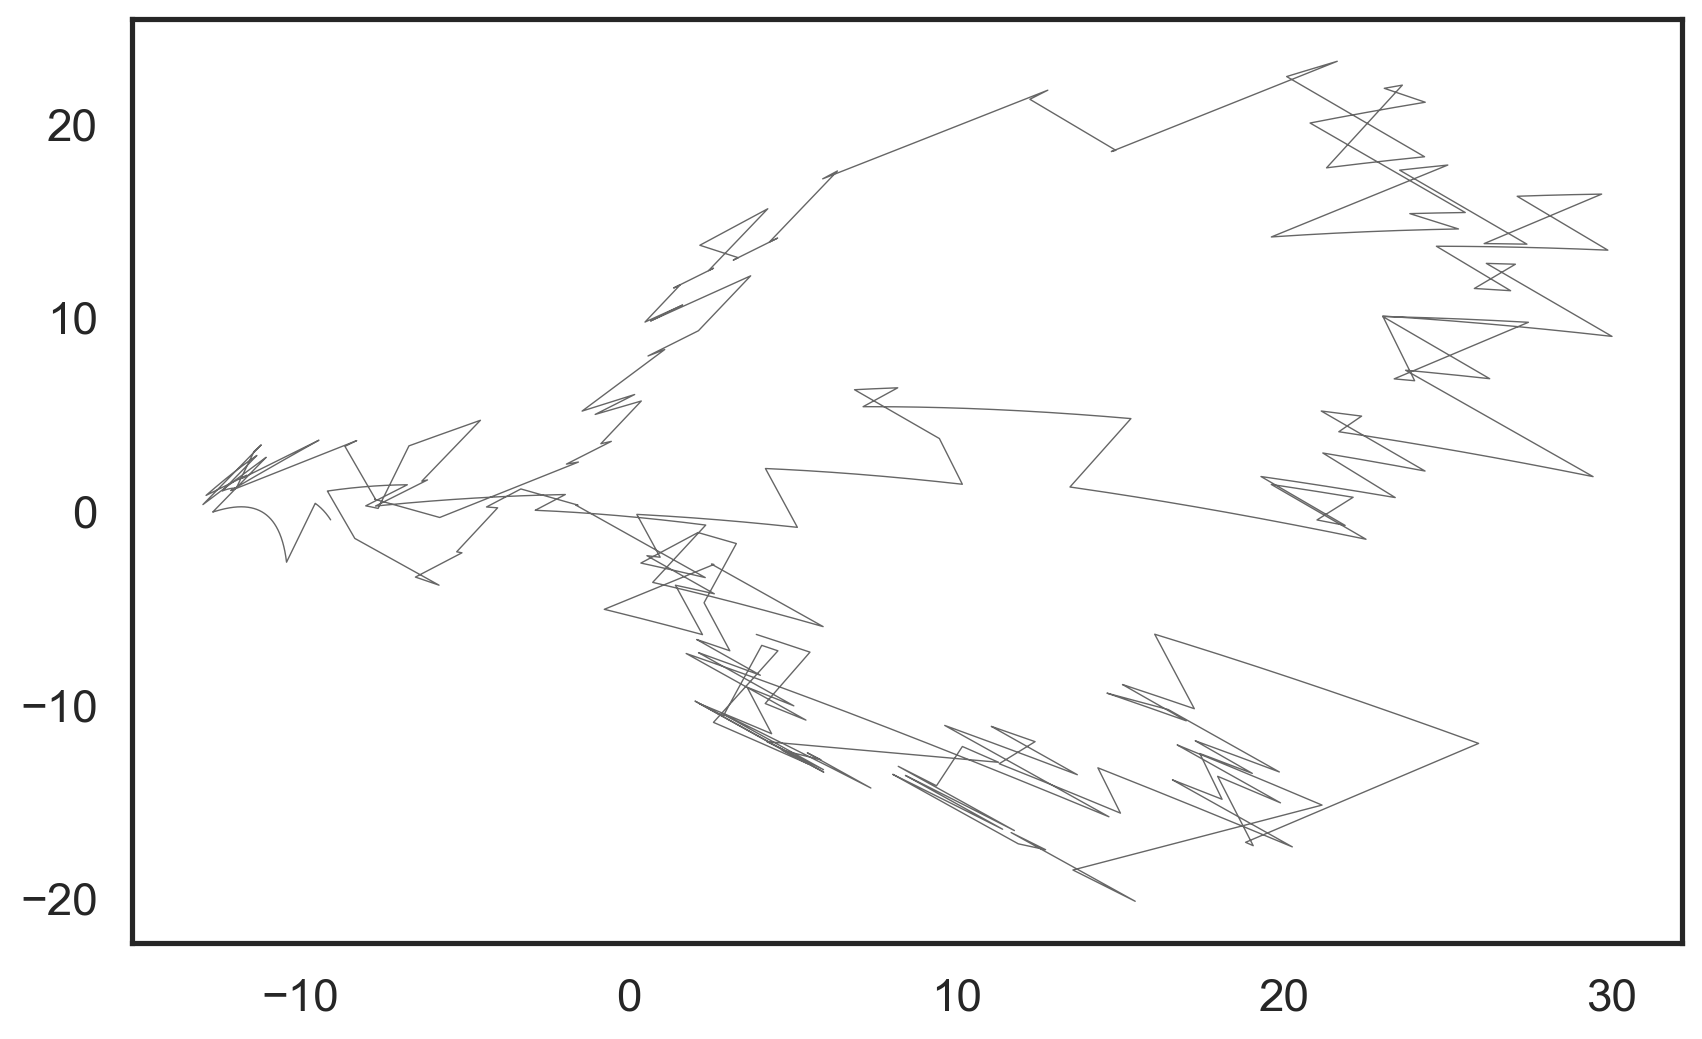

In [25]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.plot(xhat_lem_pca[:, 0],
        xhat_lem_pca[:, 1],
        lw=0.5, ls="-",
        color='k',
        alpha=0.6)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.scatter(x_values, y_values)
plt.text(x_values[0], y_values[0], "$t_{start}$")
plt.text(x_values[1], y_values[1], "$t_{end}$")
plt.title("Inferred Dynamics, Laplace-EM")

## Plot first two dimension
latent variable 중 time constant가 가장 큰 두 차원을 시간에 따라 그립니다.  
여기도 마찬가지로 색은 true state를 나타내며, 주석처리한 axvline 메소드를 이용해 trial 구분 수직선을 얼마든지 추가할 수 있습니다.

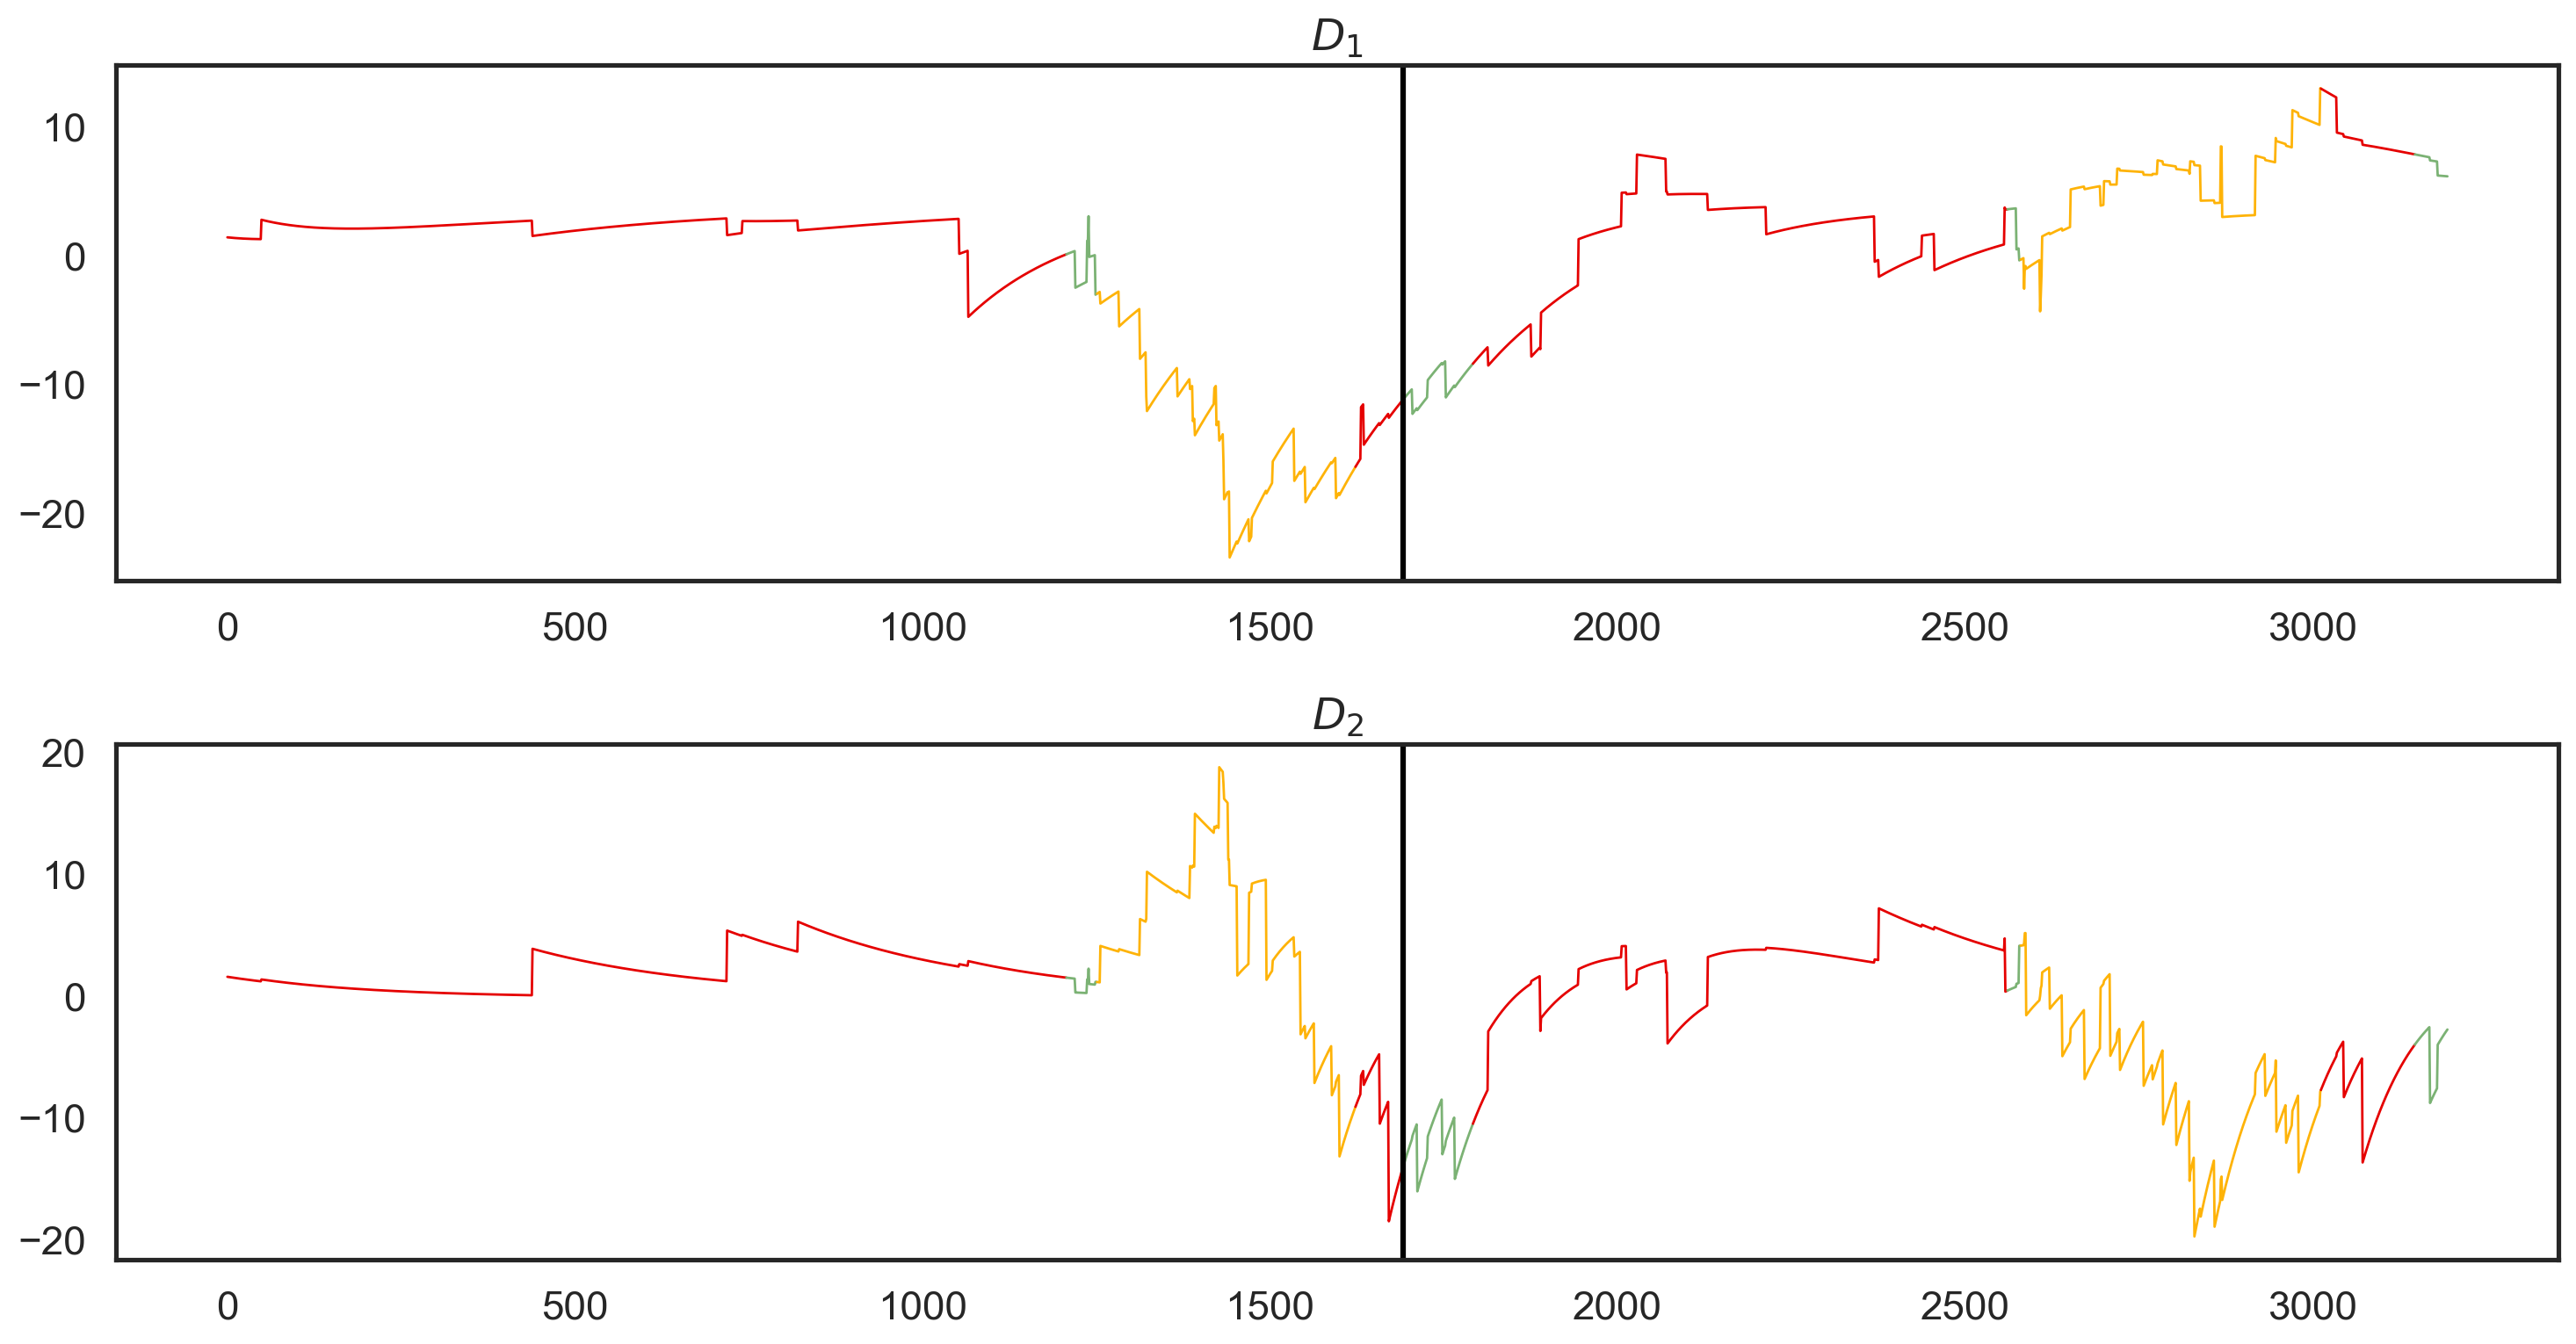

In [29]:
first_dim = xhat_lem[:, arg_sorted[0]]
second_dim = xhat_lem[:, arg_sorted[1]]

fig = plt.figure(figsize=(15, 8)) 
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

plot_observations(z[:], first_dim[:, None], ax=ax1)
plot_observations(z[:], second_dim[:, None], ax=ax2)

ax1.axvline(x=hitass_indices[0], color='black')
ax2.axvline(x=hitass_indices[0], color='black')
# ax1.axvline(x=hitass_indices[1], color='black')
# ax2.axvline(x=hitass_indices[1], color='black')

ax1.set_title("$D_1$")
ax2.set_title("$D_2$")
plt.tight_layout()

### Plot PC
PC1과 PC2를 시간에 따라 각각 그립니다. 나머지는 위의 설명과 동일합니다.

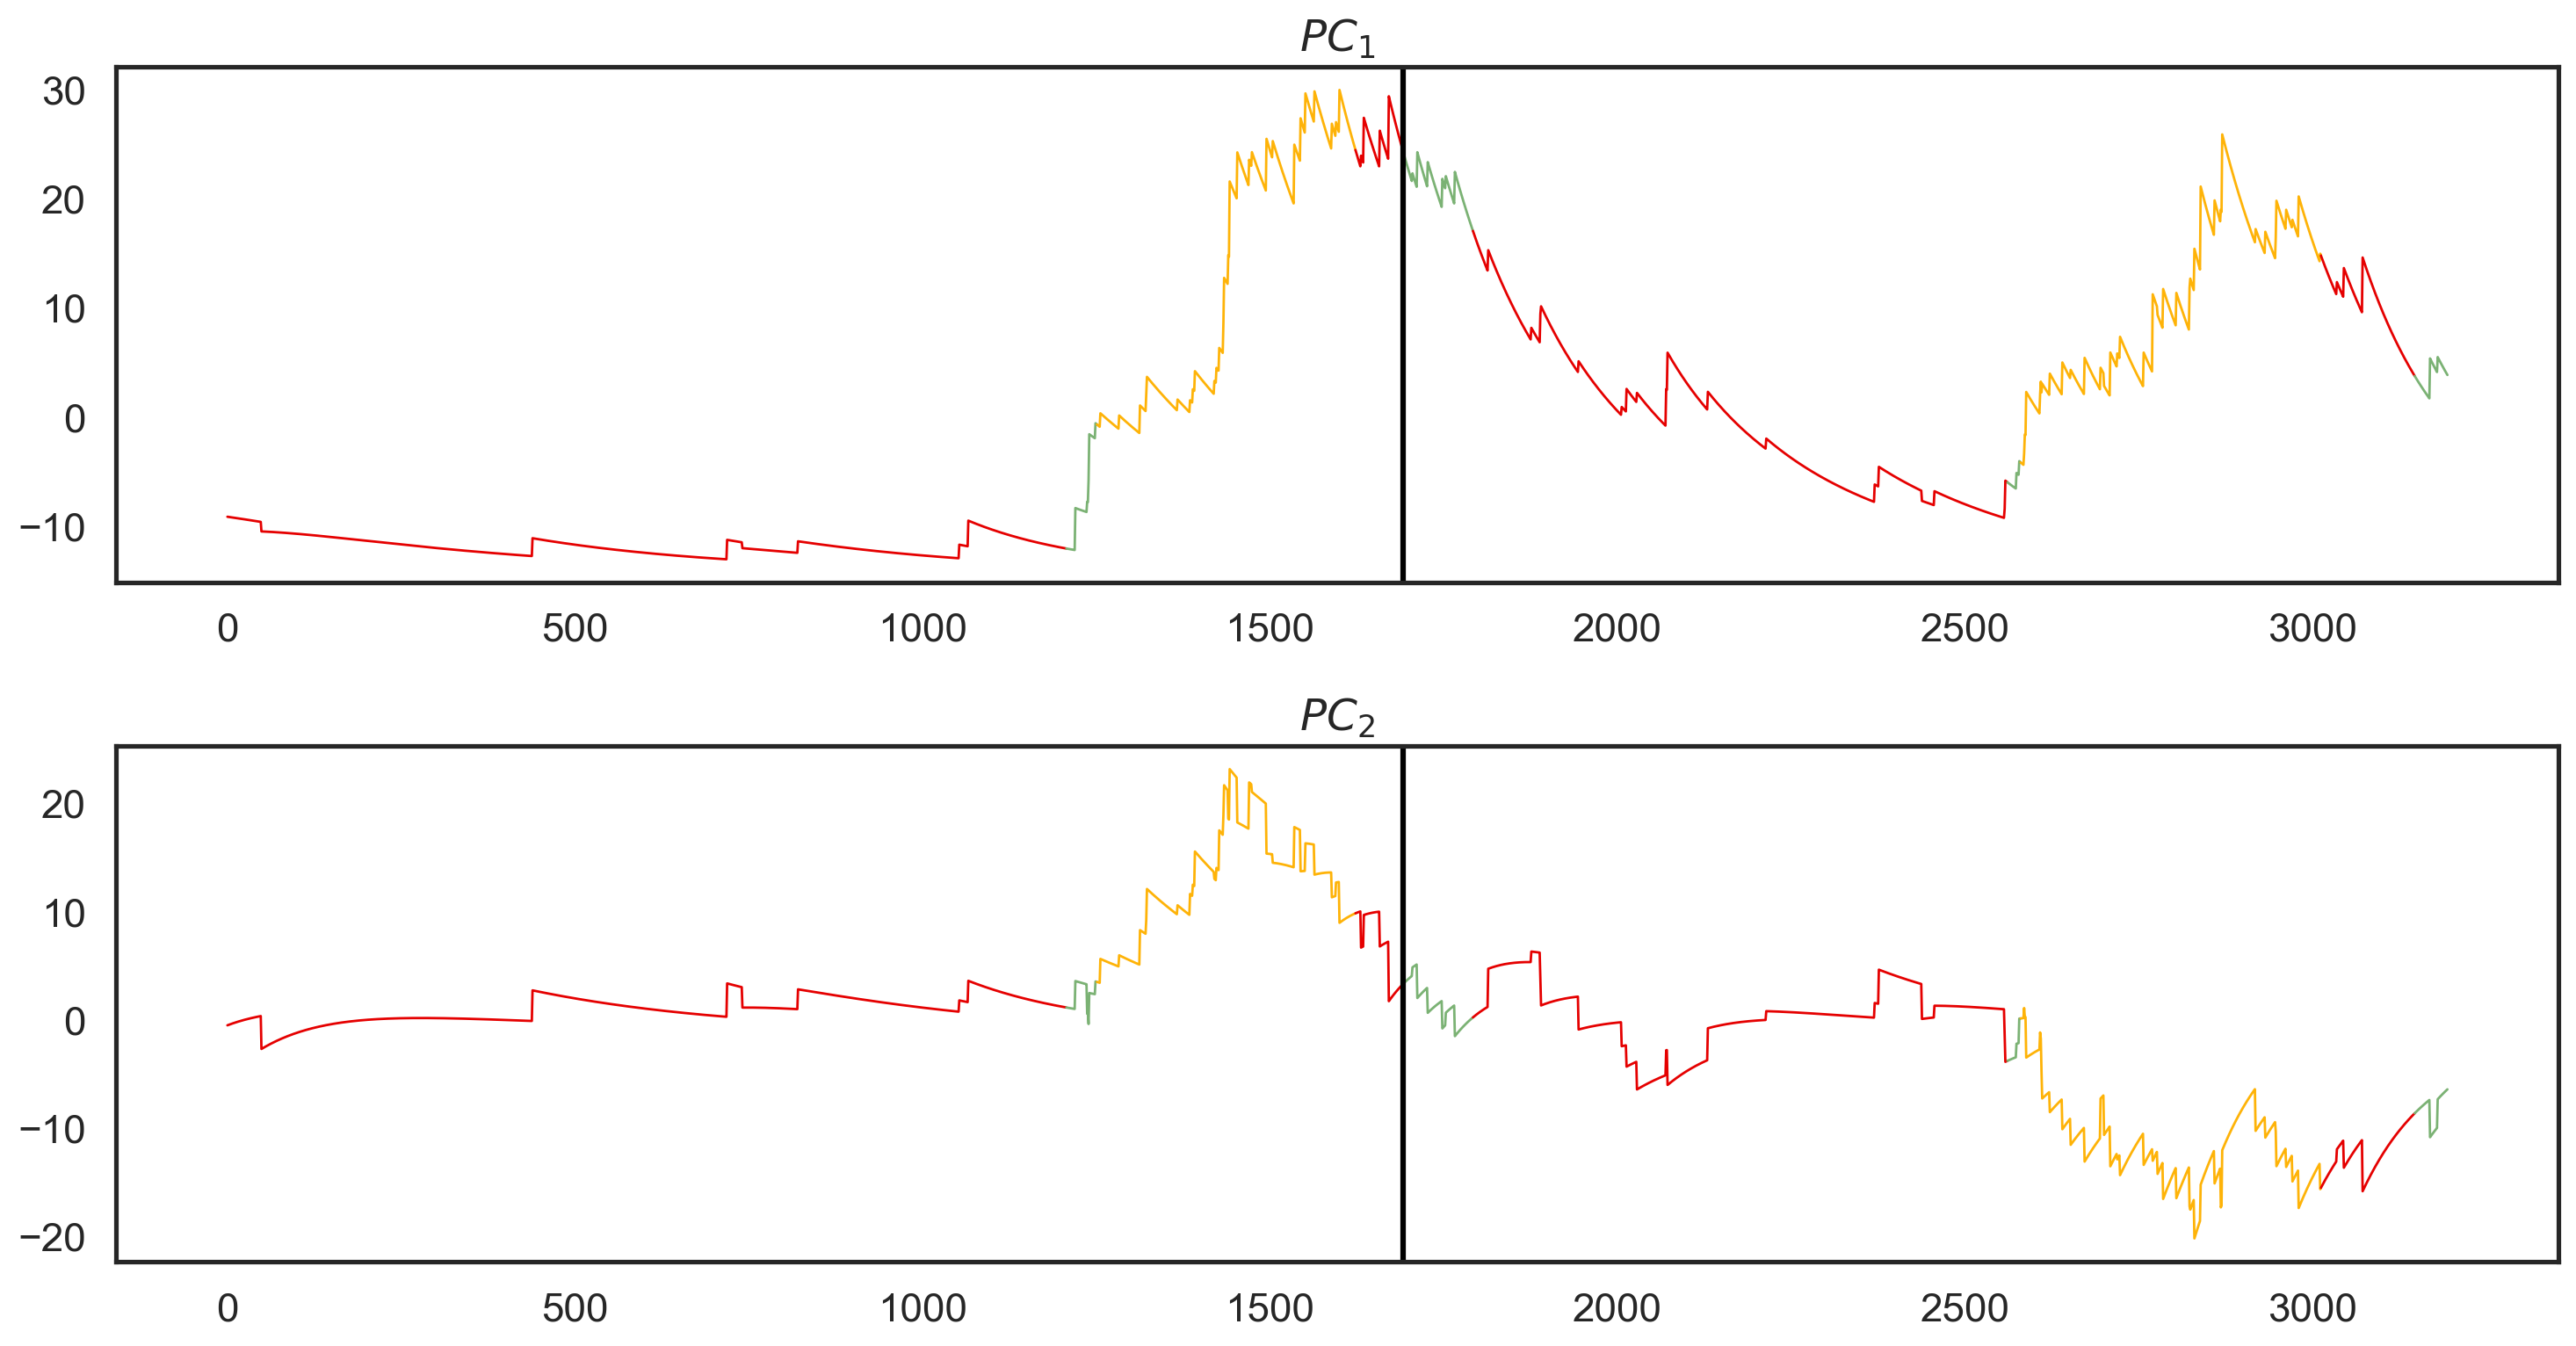

In [30]:
fig = plt.figure(figsize=(15, 8)) 
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
plot_observations(z[:], xhat_lem_pca[:, 0:1], ax=ax1)
plot_observations(z[:], xhat_lem_pca[:, 1:2], ax=ax2)
ax1.axvline(x=hitass_indices[0], color='black')
ax2.axvline(x=hitass_indices[0], color='black')
# ax1.axvline(x=hitass_indices[1], color='black')
# ax2.axvline(x=hitass_indices[1], color='black')

ax1.set_title("$PC_1$")
ax2.set_title("$PC_2$")
plt.tight_layout()